# External Dependencies for Typescript
<br>  

### References
- [jqassistant](https://jqassistant.org)
- [Neo4j Python Driver](https://neo4j.com/docs/api/python-driver/current)

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plot
from neo4j import GraphDatabase

In [2]:
# Please set the environment variable "NEO4J_INITIAL_PASSWORD" in your shell 
# before starting jupyter notebook to provide the password for the user "neo4j". 
# It is not recommended to hardcode the password into jupyter notebook for security reasons.

driver = GraphDatabase.driver(uri="bolt://localhost:7687", auth=("neo4j", os.environ.get("NEO4J_INITIAL_PASSWORD")))
driver.verify_connectivity()

In [3]:
def get_cypher_query_from_file(filename):
    with open(filename) as file:
        return ' '.join(file.readlines())

In [4]:
def query_cypher_to_data_frame(filename):
    records, summary, keys = driver.execute_query(get_cypher_query_from_file(filename))
    return pd.DataFrame([r.values() for r in records], columns=keys)

In [5]:
def group_to_others_below_threshold(data_frame : pd.DataFrame, value_column : str, name_column: str, threshold: float) -> pd.DataFrame:    
    """
    Adds a new percentage column for the value column and 
    groups all values below the given threshold to "others" in the name column.

    Parameters:
    - data_frame (pd.DataFrame): Input pandas DataFrame
    - value_column (str): Name of the column that contains the numeric value
    - name_column (str): Name of the column that contains the group name that will be replaced by "others" for small values
    - threshold (float): Threshold in % that is used to group values below it into the "others" group

    Returns:
    int:Returning value

    """
    result_data_frame = data_frame[[name_column, value_column]].copy();

    percent_column_name = value_column + 'Percent';

    # Add column with the name given in "percent_column_name" with the percentage of the value column.
    result_data_frame[percent_column_name] = result_data_frame[value_column] / result_data_frame[value_column].sum() * 100.0;

    # Convert name column to string values if it wasn't of that type before
    result_data_frame[name_column] = result_data_frame[name_column].astype(str)

    # Change the group name to "others" if it is called less than the specified threshold
    result_data_frame.loc[result_data_frame[percent_column_name] < threshold, name_column] = 'others';

    # Group by name column (foremost the new "others" entries) and sum their percentage
    #result_data_frame = result_data_frame.groupby(name_column)[percent_column_name].sum();
    result_data_frame = result_data_frame.groupby(name_column).sum();
    # Sort by values descending
    #return result_data_frame.sort_values(ascending=False).to_frame();
    return result_data_frame.sort_values(by=percent_column_name, ascending=False);

In [6]:
def filter_values_below_threshold(data_frame : pd.DataFrame, value_column : str, upper_limit: float = 100.0) -> pd.DataFrame:    
    """
    Adds a new percentage column for the value column and 
    groups all values below the given threshold to "others" in the name column.

    Parameters:
    - data_frame (pd.DataFrame): Input pandas DataFrame
    - value_column (str): Name of the column that contains the numeric value
    - upper_limit (float): Defaults to 100%. Filters out all entries exceeding this limit. Intended to drill down "others" in a second chart/table.

    Returns:
    int:Returning value

    """
    result_data_frame = data_frame.copy();

    percent_column_name = value_column + 'Percent';

    # Add column with the name given in "percent_column_name" with the percentage of the value column.
    result_data_frame[percent_column_name] = result_data_frame[value_column] / result_data_frame[value_column].sum() * 100.0;

    # Limit entries to meet the an optional upper limit (in percentage)
    result_data_frame = result_data_frame.query("`" + percent_column_name + "` <= " + str(upper_limit))

    result_data_frame = result_data_frame.reset_index(drop=True)
    return result_data_frame.sort_values(by=percent_column_name, ascending=False);

In [7]:
def explode_index_value(input_data_frame: pd.DataFrame, index_value_to_emphasize: str = 'others', base_value: float = 0.02, emphasize_value: float = 0.2):
    """
    "Explode" offsets slices in a pie chart plot by a given value.
    The specified index value will be emphasized with a larger value to make it stand out in the pie chart plot.

    Parameters:
    - input_data_frame (pd.DataFrame): Input pandas DataFrame with the data that will be plot. (Required)
    - index_value_to_emphasize (str): Value of the index that will be emphasized. (Default= 'others')
    - base_value (float): Base value for all pies in the chart. (Default=0.02)
    - emphasize_value (float): Value for the emphasized pie in the chart. (Default=0.2)

    Returns:
    Array with the same size as the number of rows/pies to plot containing the "explode" value for each of them

    """
    # Each entry in the list corresponds to an x value
    # The comparison with the index_value_to_emphasize produces an array of booleans where nth entry with the emphasized value is "true"
    # Multiplying it leads to 1 for True and 0 for False therefore "exploding" the emphasized entry whilst 
    return (input_data_frame.index == index_value_to_emphasize) * emphasize_value + base_value     

In [8]:
def plot_pie_chart(input_data_frame: pd.DataFrame, title: str):
    if input_data_frame.empty:
        print("No data to plot for title '" + title + "'.")
        return
    
    name_of_the_first_column_containing_the_values=input_data_frame.columns[0]
    total_sum = input_data_frame[name_of_the_first_column_containing_the_values].sum()
    
    def custom_auto_percentage_format(percentage):
        return '{:1.2f}% ({:.0f})'.format(percentage, total_sum * percentage / 100.0)
        
    plot.figure();

    axis = input_data_frame.plot(
        kind='pie',
        y=name_of_the_first_column_containing_the_values + 'Percent',
        ylabel='',
        legend=True,
        labeldistance=None,
        autopct=custom_auto_percentage_format,
        textprops={'fontsize': 6},
        pctdistance=1.15,
        cmap=main_color_map,
        figsize=(9,9),
        explode=explode_index_value(input_data_frame, index_value_to_emphasize='others')
    )
    plot.title(title, pad=15)
    axis.legend(bbox_to_anchor=(1.08, 1), loc='upper left')
    plot.show()

In [9]:
#The following cell uses the build-in %html "magic" to override the CSS style for tables to a much smaller size.
#This is especially needed for PDF export of tables with multiple columns.

In [10]:
%%html
<style>
/* CSS style for smaller dataframe tables. */
.dataframe th {
    font-size: 8px;
}
.dataframe td {
    font-size: 8px;
}
</style>

In [11]:
# Main Colormap
main_color_map = 'nipy_spectral'

## External Typescript Module Usage

### External Module

An external Typescript module is marked with the label `ExternalModule` and the declarations it provides with  `ExternalDeclaration`. In practice, the distinction between internal and external isn't always that clear. When there is a problem following the project configuration like discussed in [Missing Interfaces and other elements in the Graph](https://github.com/jqassistant-plugin/jqassistant-typescript-plugin/issues/35), some internal dependencies might be imported as external ones. 

To have a second indicator, the property `isNodeModule` is written with [Add_module_properties.cypher](./../cypher/Typescript_Enrichment/Add_module_properties.cypher) in [prepareAnalysis.sh](./../scripts/prepareAnalysis.sh). For most package managers this should then be sufficient. As of now (June 2024), it might not work with [Yarn Plug'n'Play](https://yarnpkg.com/features/pnp).

### Table 1 - Top 20 most used external packages overall

This table shows the external packages that are used by the most different internal types overall.
Additionally, it shows which types of the external modules are actually used. External annotations are also listed.

Only the top 20 entries are shown. The whole table can be found in the following CSV report:
`External_module_usage_overall_for_Typescript`

**Columns:**
- *externalModuleName* is the name of the external module prepended by its namespace if given. Example: "@types/react"
- *numberOfExternalCallerModules* is the number of modules that use that external module
- *numberOfExternalCallerElements* is the number of elements (functions, classes,...) that use that external module
- *numberOfExternalDeclarationCalls* is how often the external declarations of that external module are imported
- *numberOfExternalDeclarationCallsWeighted* is how often the external declarations of that external module are actually used
- *allModules* contains the total count of all analyzed internal modules
- *allInternalElements* contains the total count of all analyzed exported internal elements (function, classes,...)
- *exampleStories* contains a list of sentences that contain concrete examples (for explanation and debugging)

In [12]:
external_module_usage=query_cypher_to_data_frame("../cypher/External_Dependencies/External_module_usage_overall_for_Typescript.cypher")

# Select columns and only show the first 20 entries (head)
external_module_usage.head(20)

,externalModuleName,numberOfExternalCallerModules,numberOfExternalCallerElements,numberOfExternalDeclarationCalls,numberOfExternalDeclarationCallsWeighted,allModules,allInternalElements,exampleStories
0,@types/react,5,35,195,584,12,109,[<mapRouteProperties> of module <react-router>...
1,@remix-run/router,4,37,380,673,12,109,[<createMemoryRouter> of module <react-router>...
2,@types/react-native,1,5,28,57,12,109,[<LinkProps> of module <react-router-native> i...
3,@ungap/url-search-params,1,2,4,8,12,109,[<createSearchParams> of module <react-router-...


#### Table 1 Chart 1a - Most called external modules in % by internal elements (more than 0.7% overall)

External modules that are used less than 0.7% are grouped into "others" to get a cleaner chart
containing the most significant external modules and how ofter they are called by internal elements in percent.

<Figure size 640x480 with 0 Axes>

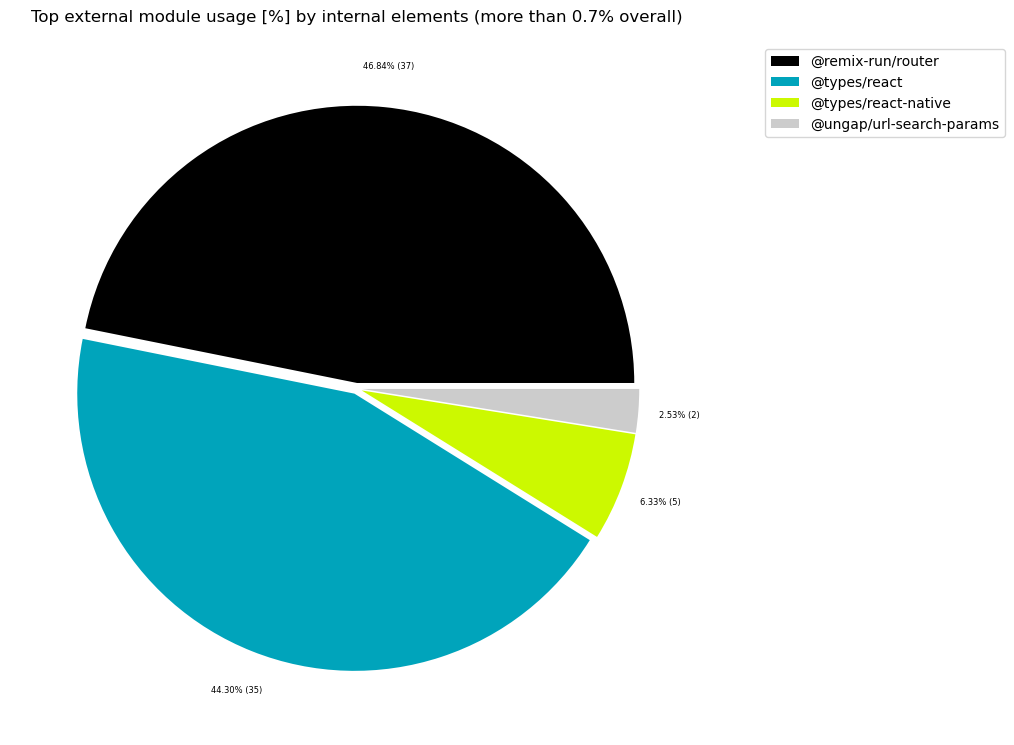

In [13]:
external_module_by_internal_element_usage_significant = group_to_others_below_threshold(
    data_frame=external_module_usage,
    value_column='numberOfExternalCallerElements',
    name_column='externalModuleName',
    threshold= 0.7
);
plot_pie_chart(
    input_data_frame=external_module_by_internal_element_usage_significant,
    title='Top external module usage [%] by internal elements (more than 0.7% overall)'
)

#### Table 1 Chart 1b - Most called external modules in % by internal elements (less than 0.7% overall "others" drill-down)

Shows the lowest (less than 0.7% overall) most called external modules. Therefore, this plot breaks down the "others" slice of the pie chart above. Values under 0.3% from that will be grouped into "others" to get a cleaner plot.

In [14]:
external_module_by_internal_element_usage_drill_down_others=filter_values_below_threshold(external_module_usage, 'numberOfExternalCallerElements', 0.7)

external_module_by_internal_element_usage_significant_drill_down_others = group_to_others_below_threshold(
    data_frame=external_module_by_internal_element_usage_drill_down_others,
    value_column='numberOfExternalCallerElements',
    name_column='externalModuleName',
    threshold= 0.3
)
plot_pie_chart(
    input_data_frame=external_module_by_internal_element_usage_significant_drill_down_others,
    title='Top external module usage [%] by internal elements  (less than 0.7% overall "others" drill-down)'
)

No data to plot for title 'Top external module usage [%] by internal elements  (less than 0.7% overall "others" drill-down)'.


#### Table 1 Chart 2a - Most called external modules in % by internal modules (more than 0.7% overall)

External modules that are used less than 0.7% are grouped into "others" to get a cleaner chart
containing the most significant external modules and how ofter they are called by internal modules in percent.

<Figure size 640x480 with 0 Axes>

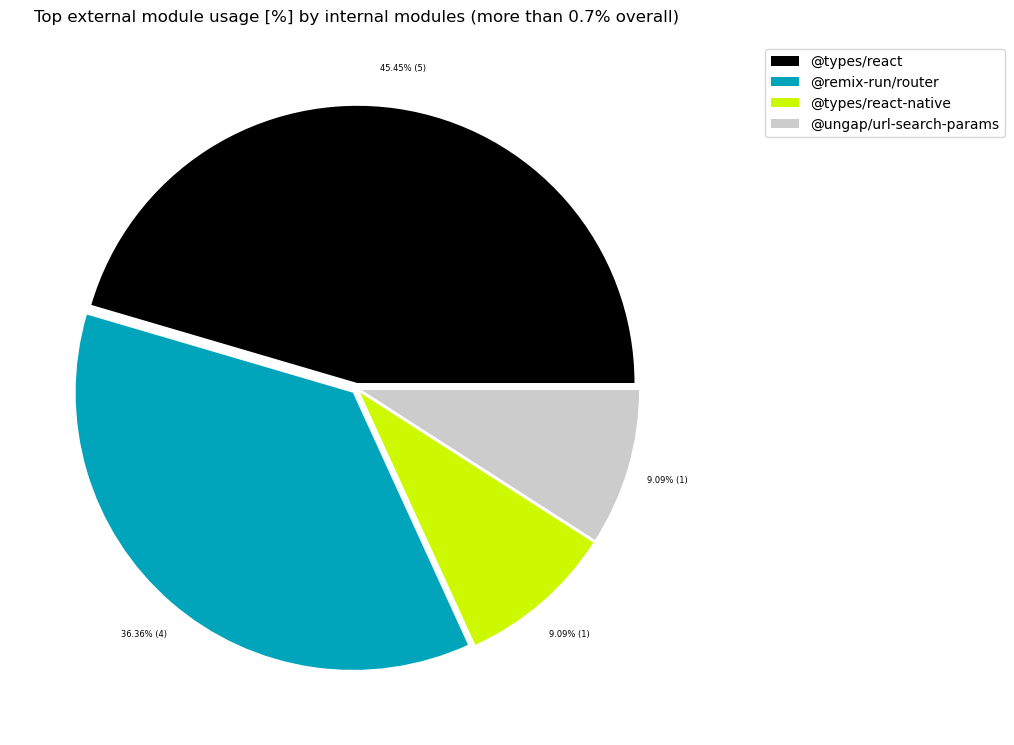

In [15]:
external_module_used_by_internal_modules_significant = group_to_others_below_threshold(
    data_frame=external_module_usage,
    value_column='numberOfExternalCallerModules',
    name_column='externalModuleName',
    threshold= 0.7
);
plot_pie_chart(
    input_data_frame=external_module_used_by_internal_modules_significant,
    title='Top external module usage [%] by internal modules (more than 0.7% overall)'
)

#### Table 1 Chart 2b - Most called external modules in % by internal modules (less than 0.7% overall "others" drill-down)

Shows the lowest (less than 0.7% overall) most called external modules. Therefore, this plot breaks down the "others" slice of the pie chart above. Values under 0.3% from that will be grouped into "others" to get a cleaner plot.

In [16]:
external_module_used_by_internal_modules_drill_down_others=filter_values_below_threshold(external_module_usage, 'numberOfExternalCallerModules', 0.7)

external_module_used_by_internal_modules_significant_drill_down_others = group_to_others_below_threshold(
    data_frame=external_module_used_by_internal_modules_drill_down_others,
    value_column='numberOfExternalCallerModules',
    name_column='externalModuleName',
    threshold= 0.3
)
plot_pie_chart(
    input_data_frame=external_module_used_by_internal_modules_significant_drill_down_others,
    title='Top external module usage [%] by internal modules (less than 0.7% overall "others" drill-down)'
)

No data to plot for title 'Top external module usage [%] by internal modules (less than 0.7% overall "others" drill-down)'.


### Table 2 - Top 20 most used external namespaces

This table shows external namespaces that are used by the most different internal elements (functions, classes,...) overall. 

Additionally, it shows how many of the declarations of the external namespace are actually used.

Only the top 20 entries are shown. The whole table can be found in the following CSV report:
`External_namespace_usage_overall_for_Typescript`

**Columns:**
- *externalNamespaceName* is the name of the external namespace (empty if none). Example: "@types". All other columns are aggregated/grouped by it.
- *numberOfExternalCallerModules* is the number of modules that use that external module
- *numberOfExternalCallerElements* is the number of elements (functions, classes,...) that use that external module
- *numberOfExternalDeclarationCalls* is how often the external declarations of that external module are imported
- *numberOfExternalDeclarationCallsWeighted* is how often the external declarations of that external module are actually used
- *allModules* contains the total count of all analyzed internal modules
- *allInternalElements* contains the total count of all analyzed exported internal elements (function, classes,...)
- *exampleStories* contains a list of sentences that contain concrete examples (for explanation and debugging)

In [17]:
external_namespace_usage=query_cypher_to_data_frame("../cypher/External_Dependencies/External_namespace_usage_overall_for_Typescript.cypher")
external_namespace_usage.head(20)

,externalNamespaceName,numberOfExternalCallerModules,numberOfExternalCallerElements,numberOfExternalDeclarationCalls,numberOfExternalDeclarationCallsWeighted,allModules,allInternalElements,exampleStories
0,@types,5,36,223,641,12,109,[<mapRouteProperties> of module <react-router>...
1,@remix-run,4,37,380,673,12,109,[<createMemoryRouter> of module <react-router>...
2,@ungap,1,2,4,8,12,109,[<createSearchParams> of module <react-router-...


#### Table 2 Chart 1a - Most called external namespaces in % by internal element (more than 0.7% overall)

External namespaces that are used less than 0.7% are grouped into "others" to get a cleaner chart
containing the most significant external namespaces and how ofter they are called by internal elements in percent.

<Figure size 640x480 with 0 Axes>

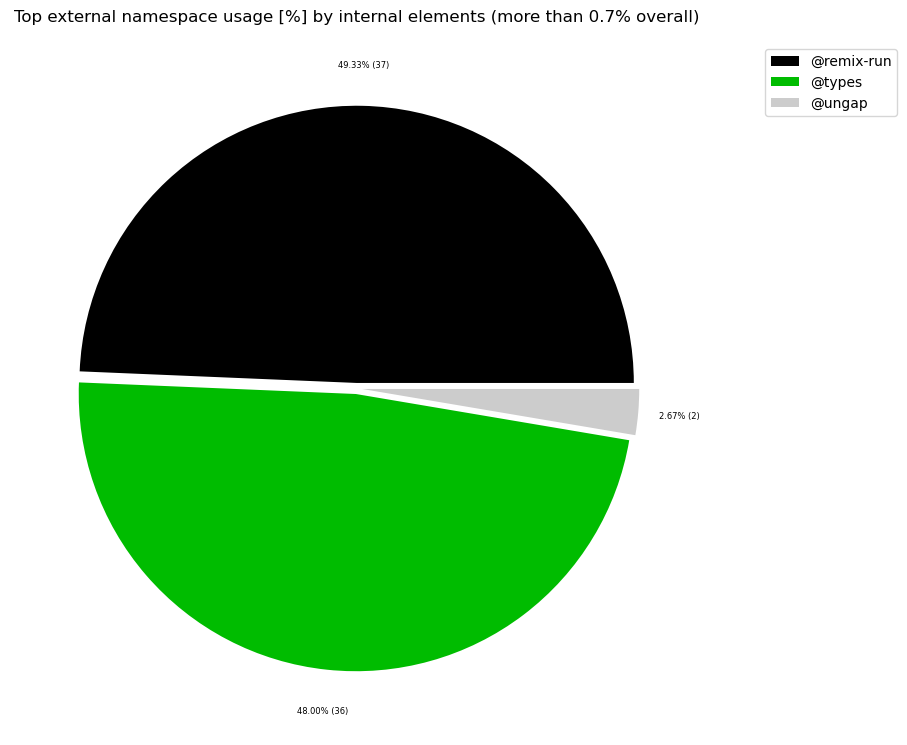

In [18]:
external_namespace_use_by_internal_elements_significantly = group_to_others_below_threshold(
    data_frame=external_namespace_usage,
    value_column='numberOfExternalCallerElements',
    name_column='externalNamespaceName',
    threshold= 0.7
);
plot_pie_chart(
    input_data_frame=external_namespace_use_by_internal_elements_significantly,
    title='Top external namespace usage [%] by internal elements (more than 0.7% overall)'
)

#### Table 2 Chart 1a - Most called external namespaces in % by internal element (less than 0.7% overall "others" drill-down)

Shows the lowest (less than 0.7% overall) most called external namespaces. Therefore, this plot breaks down the "others" slice of the pie chart above. Values under 0.3% from that will be grouped into "others" to get a cleaner plot.

In [19]:
external_namespace_use_by_internal_elements_drill_down_others=filter_values_below_threshold(external_namespace_usage, 'numberOfExternalCallerElements', 0.7)

external_namespace_use_by_internal_elements_significant_drill_down_others = group_to_others_below_threshold(
    data_frame=external_namespace_use_by_internal_elements_drill_down_others,
    value_column='numberOfExternalCallerElements',
    name_column='externalNamespaceName',
    threshold= 0.3
)
plot_pie_chart(
    input_data_frame=external_namespace_use_by_internal_elements_significant_drill_down_others,
    title='Top external namespace usage [%] by internal elements (less than 0.7% overall "others" drill-down)'
)

No data to plot for title 'Top external namespace usage [%] by internal elements (less than 0.7% overall "others" drill-down)'.


#### Table 2 Chart 2a - Most called external namespaces in % by internal modules (more than 0.7% overall)

External namespaces that are used less than 0.7% are grouped into "others" to get a cleaner chart
containing the most significant external namespaces and how ofter they are called by internal modules in percent.

<Figure size 640x480 with 0 Axes>

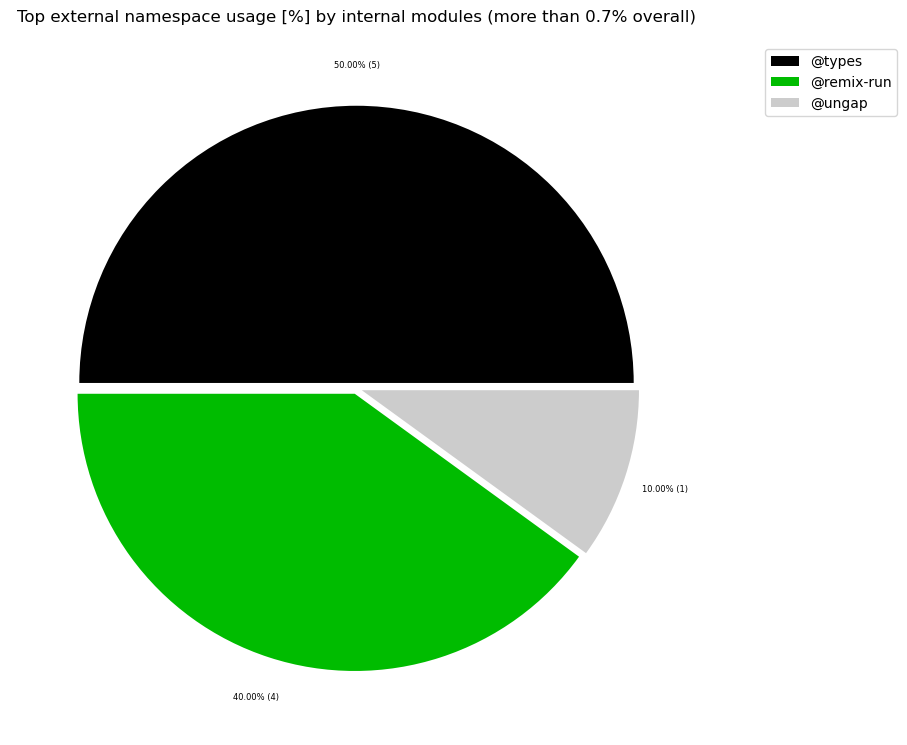

In [20]:
external_namespace_used_by_internal_modules_significantly = group_to_others_below_threshold(
    data_frame=external_namespace_usage,
    value_column='numberOfExternalCallerModules',
    name_column='externalNamespaceName',
    threshold= 0.7
);
plot_pie_chart(
    input_data_frame=external_namespace_used_by_internal_modules_significantly,
    title='Top external namespace usage [%] by internal modules (more than 0.7% overall)'
)

#### Table 2 Chart 2b - Most called external namespaces in % by internal modules (less than 0.7% overall "others" drill-down)

Shows the lowest (less than 0.7% overall) most called external namespaces. Therefore, this plot breaks down the "others" slice of the pie chart above. Values under 0.3% from that will be grouped into "others" to get a cleaner plot.

In [21]:
external_namespace_used_by_internal_modules_drill_down_others=filter_values_below_threshold(external_namespace_usage, 'numberOfExternalCallerModules', 0.7)

external_namespace_used_by_internal_modules_significant_drill_down_others = group_to_others_below_threshold(
    data_frame=external_namespace_used_by_internal_modules_drill_down_others,
    value_column='numberOfExternalCallerModules',
    name_column='externalNamespaceName',
    threshold= 0.3
)
plot_pie_chart(
    input_data_frame=external_namespace_used_by_internal_modules_significant_drill_down_others,
    title='Top external namespace usage [%] by internal modules (less than 0.7% overall "others" drill-down)'
)

No data to plot for title 'Top external namespace usage [%] by internal modules (less than 0.7% overall "others" drill-down)'.


### Table 3 - Top 20 most widely spread external modules

The following tables shows external modules that are used by many different internal modules with the highest number of artifacts first.

Statistics like minimum, maximum, average, median and standard deviation are provided for the number of internally exported elements (function, class, ...) and the external declarations they use for every external module. 

The intuition behind that is to find external modules and the external declarations they provide that are used in a widely spread manner. This can help to distinguish widely used libraries and frameworks from external modules that are used for specific tasks. It can also be used to find external modules that are used sparsely regarding internal modules but where many different external declarations are used. 

Refactoring with [Hexagonal architecture](https://alistair.cockburn.us/hexagonal-architecture) in mind can be considered for non-framework external modules that are used for very specific tasks and that are used in many different internal locations. This makes the internal code more robust against changes of these external modules or it is easier to update and migrate to newer versions of them. 

External modules that are only used in very few internal locations overall might be considered for removal if they are easy to replace with a similar library that is already used more often. Or they might also simply be replaced by very few lines of code. Replacing libraries with own code isn't recommended when you need to write a lot of code or for external modules that provide security relevant implementations (encryption, sanitizers, ...), because they will be tracked and maintained globally and security updates need to be adopted fast.

Only the top 20 entries are shown. The whole table can be found in the following CSV report:
`External_module_usage_spread_for_Typescript`

**Columns:**
- *externalModuleName* is the name of the external package prepended by its namespace if given. Example: "@types/react"
external package.
- *numberOfInternalModules* is the number of internal modules that are using that external module
- *\[min,max,med,avg,std\]NumberOfUsedExternalDeclarations* provide statistics for all internal modules and how their usage of the declarations provided by the external module are distributed. This provides an indicator on how strong the coupling to the external module is. For example, if many (high sum) elements provided by that external module are used constantly (low std), a higher coupling can be presumed. If there is only one (sum) element in use, this could be an indicator for an external module that could get replaced or that there is just one central entry point for it.
- *\[min/max/med/avg/std\]NumberOfInternalElements* provide statistics for all internal modules and how their usage of the external module is distributed across their internal elements. This provides an indicator on how widely an external module is spread across internal elements and if there are great differences between internal modules (high standard deviation) or not.
- *\[min/max/med/avg/std\]NumberOfInternalElementsPercentage* is similar to [min/max/med/avg/std]NumberOfUsedExternalDeclarations but provides the value in percent in relation to the total number of internal elements per internal module.
- *internalModuleExamples* some examples of included internal modules for debugging

In [22]:
# Query the graph database to provide the 
# most widely spread external dependencies for the tables/charts below.
external_module_usage_spread=query_cypher_to_data_frame("../cypher/External_Dependencies/External_module_usage_spread_for_Typescript.cypher")
external_module_usage_spread.head(10)

,externalModuleName,numberOfInternalModules,sumNumberOfUsedExternalDeclarations,minNumberOfUsedExternalDeclarations,maxNumberOfUsedExternalDeclarations,medNumberOfUsedExternalDeclarations,avgNumberOfUsedExternalDeclarations,stdNumberOfUsedExternalDeclarations,sumNumberOfInternalElements,minNumberOfInternalElements,maxNumberOfInternalElements,medNumberOfInternalElements,avgNumberOfInternalElements,stdNumberOfInternalElements,minNumberOfInternalElementsPercentage,maxNumberOfInternalElementsPercentage,medNumberOfInternalElementsPercentage,avgNumberOfInternalElementsPercentage,stdNumberOfInternalElementsPercentage,internalModuleExamples
0,@types/react,5,38,1,27,2.0,7.6,11.126545,35,1,24,3.0,7.00,9.721111,8.333333,200.000000,25.000000,58.333333,81.009259,"[react-router, react-router-dom, server, react..."
1,@remix-run/router,4,128,6,88,17.0,32.0,38.401389,37,3,23,5.5,9.25,9.251126,25.000000,191.666667,45.833333,77.083333,77.092717,"[react-router, react-router-dom, server, react..."
2,@types/react-native,1,10,10,10,10.0,10.0,0.000000,5,5,5,5.0,5.00,0.000000,41.666667,41.666667,41.666667,41.666667,0.000000,[react-router-native]
3,@ungap/url-search-params,1,1,1,1,1.0,1.0,0.000000,2,2,2,2.0,2.00,0.000000,16.666667,16.666667,16.666667,16.666667,0.000000,[react-router-native]


### Table 3a - Top 20 most widely spread external packages - number of internal modules

This table shows the top 20 most widely spread external packages focussing on the spread across the number of internal modules.

In [23]:
external_package_usage_spread_packages=external_module_usage_spread[['externalModuleName', 'numberOfInternalModules', 'minNumberOfInternalElements', 'maxNumberOfInternalElements', 'medNumberOfInternalElements', 'avgNumberOfInternalElements', 'stdNumberOfInternalElements']]
external_package_usage_spread_packages.head(20)

,externalModuleName,numberOfInternalModules,minNumberOfInternalElements,maxNumberOfInternalElements,medNumberOfInternalElements,avgNumberOfInternalElements,stdNumberOfInternalElements
0,@types/react,5,1,24,3.0,7.00,9.721111
1,@remix-run/router,4,3,23,5.5,9.25,9.251126
2,@types/react-native,1,5,5,5.0,5.00,0.000000
3,@ungap/url-search-params,1,2,2,2.0,2.00,0.000000


### Table 3b - Top 20 most widely spread external packages - percentage of internal modules

This table shows the top 20 most widely spread external packages focussing on the spread across the percentage of internal modules.

In [24]:
external_package_usage_spread_packages_percentage=external_module_usage_spread[['externalModuleName', 'numberOfInternalModules', 'minNumberOfInternalElementsPercentage', 'maxNumberOfInternalElementsPercentage', 'medNumberOfInternalElementsPercentage', 'avgNumberOfInternalElementsPercentage', 'stdNumberOfInternalElementsPercentage']]
external_package_usage_spread_packages_percentage.head(20)

,externalModuleName,numberOfInternalModules,minNumberOfInternalElementsPercentage,maxNumberOfInternalElementsPercentage,medNumberOfInternalElementsPercentage,avgNumberOfInternalElementsPercentage,stdNumberOfInternalElementsPercentage
0,@types/react,5,8.333333,200.000000,25.000000,58.333333,81.009259
1,@remix-run/router,4,25.000000,191.666667,45.833333,77.083333,77.092717
2,@types/react-native,1,41.666667,41.666667,41.666667,41.666667,0.000000
3,@ungap/url-search-params,1,16.666667,16.666667,16.666667,16.666667,0.000000


### Table 3c - Top 20 most widely spread external packages - number of internal elements

This table shows the top 20 most widely spread external packages focussing on the spread across the number of internal elements.

In [25]:
external_package_usage_spread_types=external_module_usage_spread[['externalModuleName', 'numberOfInternalModules', 'minNumberOfInternalElements', 'maxNumberOfInternalElements', 'medNumberOfInternalElements', 'avgNumberOfInternalElements', 'stdNumberOfInternalElements']]
external_package_usage_spread_types.head(20)

,externalModuleName,numberOfInternalModules,minNumberOfInternalElements,maxNumberOfInternalElements,medNumberOfInternalElements,avgNumberOfInternalElements,stdNumberOfInternalElements
0,@types/react,5,1,24,3.0,7.00,9.721111
1,@remix-run/router,4,3,23,5.5,9.25,9.251126
2,@types/react-native,1,5,5,5.0,5.00,0.000000
3,@ungap/url-search-params,1,2,2,2.0,2.00,0.000000


### Table 3d - Top 20 most widely spread external packages - percentage of internal elements

This table shows the top 20 most widely spread external packages focussing on the spread across the percentage of internal elements.

In [26]:
external_package_usage_spread_types_percentage=external_module_usage_spread[['externalModuleName', 'numberOfInternalModules', 'minNumberOfInternalElementsPercentage', 'maxNumberOfInternalElementsPercentage', 'medNumberOfInternalElementsPercentage', 'avgNumberOfInternalElementsPercentage', 'stdNumberOfInternalElementsPercentage']]
external_package_usage_spread_types_percentage.head(20)

,externalModuleName,numberOfInternalModules,minNumberOfInternalElementsPercentage,maxNumberOfInternalElementsPercentage,medNumberOfInternalElementsPercentage,avgNumberOfInternalElementsPercentage,stdNumberOfInternalElementsPercentage
0,@types/react,5,8.333333,200.000000,25.000000,58.333333,81.009259
1,@remix-run/router,4,25.000000,191.666667,45.833333,77.083333,77.092717
2,@types/react-native,1,41.666667,41.666667,41.666667,41.666667,0.000000
3,@ungap/url-search-params,1,16.666667,16.666667,16.666667,16.666667,0.000000


#### Table 3 Chart 1a - Most widely spread external module in % by internal elements (more than 0.5% overall)

External modules that are used less than 0.5% are grouped into the name "others" to get a cleaner chart with the most significant external module.

<Figure size 640x480 with 0 Axes>

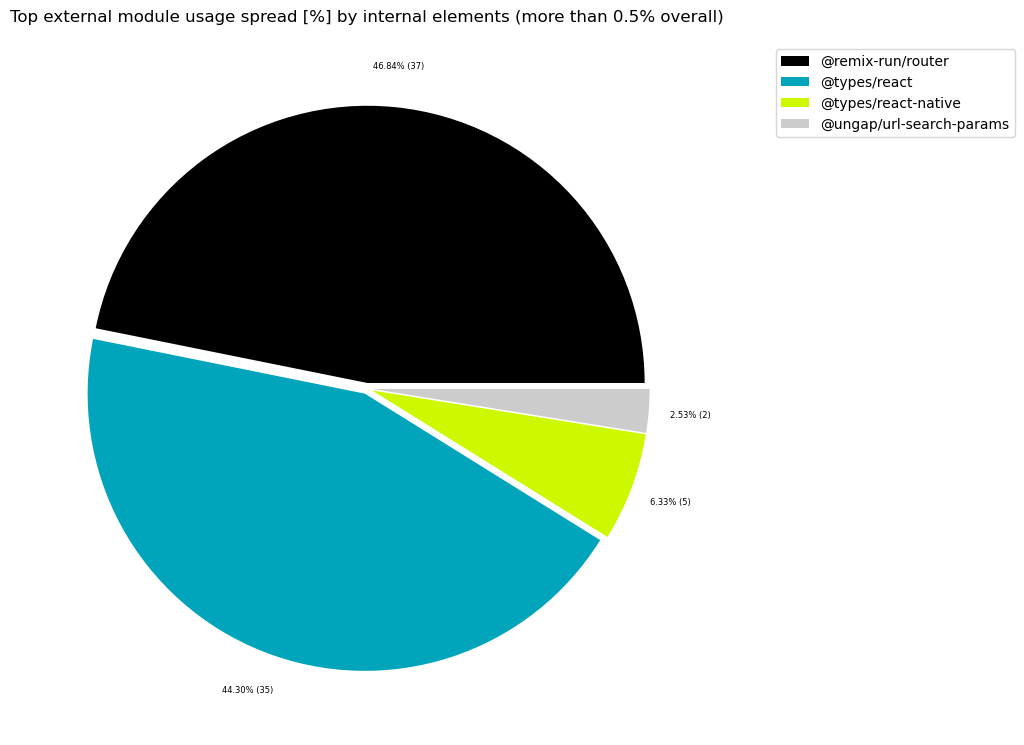

In [27]:
external_module_by_internal_element_usage_spread_significant = group_to_others_below_threshold(
    data_frame=external_module_usage_spread,
    value_column='sumNumberOfInternalElements',
    name_column='externalModuleName',
    threshold= 0.5
);
plot_pie_chart(
    input_data_frame=external_module_by_internal_element_usage_spread_significant,
    title='Top external module usage spread [%] by internal elements (more than 0.5% overall)'
)

#### Table 3 Chart 1b - Most widely spread external modules in % by types (less than 0.5% overall "others" drill-down)

Shows the lowest (less than 0.5% overall) most widely spread external modules. Therefore, this plot breaks down the "others" slice of the pie chart above. Values under 0.3% from that will be grouped into "others" to get a cleaner plot.

In [28]:
external_module_by_internal_element_usage_spread_drill_down_others=filter_values_below_threshold(external_module_usage_spread, 'sumNumberOfInternalElements', 0.5)

external_module_by_internal_element_usage_spread_significant_drill_down_others = group_to_others_below_threshold(
    data_frame=external_module_by_internal_element_usage_spread_drill_down_others,
    value_column='sumNumberOfInternalElements',
    name_column='externalModuleName',
    threshold= 0.3
)
plot_pie_chart(
    input_data_frame=external_module_by_internal_element_usage_spread_significant_drill_down_others,
    title='Top external module usage spread [%] by internal elements (less than 0.7% overall "others" drill-down)'
)

No data to plot for title 'Top external module usage spread [%] by internal elements (less than 0.7% overall "others" drill-down)'.


#### Table 3 Chart 2a - Most widely spread external modules in % by internal modules (more than 0.5% overall)

External modules that are used less than 0.5% are grouped into "others" to get a cleaner chart containing the most significant external modules.

<Figure size 640x480 with 0 Axes>

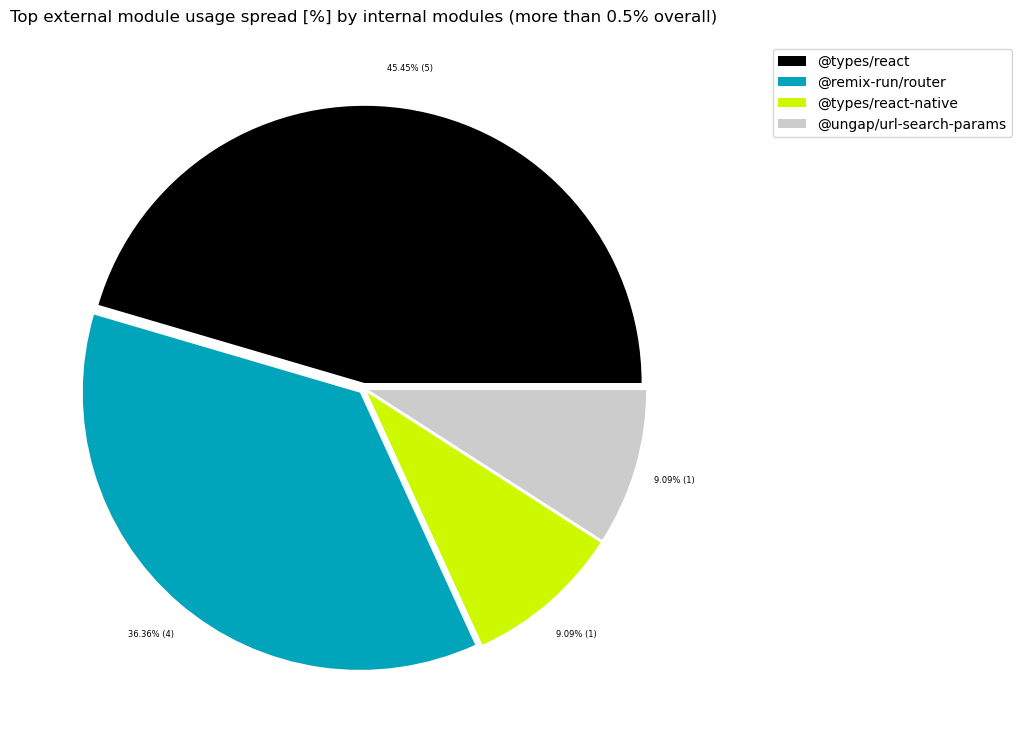

In [29]:
external_modules_used_by_internal_modules_spread_significant = group_to_others_below_threshold(
    data_frame=external_module_usage_spread,
    value_column='numberOfInternalModules',
    name_column='externalModuleName',
    threshold= 0.5
);
plot_pie_chart(
    input_data_frame=external_modules_used_by_internal_modules_spread_significant,
    title='Top external module usage spread [%] by internal modules (more than 0.5% overall)'
)

#### Table 3 Chart 2b - Most widely spread external modules in % by internal modules (less than 0.5% overall "others" drill-down)

Shows the lowest (less than 0.5% overall) most widely spread external modules. Therefore, this plot breaks down the "others" slice of the pie chart above. Values under 0.3% from that will be grouped into "others" to get a cleaner plot.

In [30]:
external_modules_used_by_internal_modules_spread_drill_down_others=filter_values_below_threshold(external_module_usage_spread, 'numberOfInternalModules', 0.5)

external_modules_used_by_internal_modules_spread_significant_drill_down_others = group_to_others_below_threshold(
    data_frame=external_modules_used_by_internal_modules_spread_drill_down_others,
    value_column='numberOfInternalModules',
    name_column='externalModuleName',
    threshold= 0.3
)
plot_pie_chart(
    input_data_frame=external_modules_used_by_internal_modules_spread_significant_drill_down_others,
    title='Top external module usage spread [%] by internal modules (less than 0.7% overall "others" drill-down)'
)

No data to plot for title 'Top external module usage spread [%] by internal modules (less than 0.7% overall "others" drill-down)'.


### Table 4 - Top 20 most widely spread external namespaces

This table shows external namespaces that are used by different internal modules with the most used first. 

Statistics like minimum, maximum, average, median and standard deviation are provided for the number of internally exported elements (function, class, ...) and the external declarations they use for every external namespace. 

The intuition behind that is to find external namespaces that are used in a widely spread manner. This can help to distinguish widely used libraries and frameworks from external modules that are used for specific tasks. It can also be used to find external modules that are used sparsely regarding internal modules but where many different external declarations are used. 

Refactoring with a [Hexagonal architecture](https://alistair.cockburn.us/hexagonal-architecture) in mind can be considered for non-framework external namespaces that are used for very specific tasks and that are used in many different internal locations. This makes the internal code more robust against changes of these external modules or it is easier to update and migrate to newer versions of them. 

External namespaces that are only used in very few internal locations overall might be considered for removal if they are easy to replace with a similar library that is already used more often. Or they might also simply be replaced by very few lines of code. Replacing libraries with own code isn't recommended when you need to write a lot of code or for external modules that provide security relevant implementations (encryption, sanitizers, ...), because they will be tracked and maintained globally and security updates need to be adopted fast.

Only the top 20 entries are shown. The whole table can be found in the following CSV report:
`External_namespace_usage_spread_for_Typescript`

**Columns:**
- *externalModuleNamespace* identifies the external namespace for at least on external module in use. All other columns contain aggregated data for it.
- *numberOfInternalModules* is the number of internal modules that are using that external module
- *\[min,max,med,avg,std\]NumberOfUsedExternalDeclarations* provide statistics for all internal modules and how their usage of the declarations provided by the external module are distributed. This provides an indicator on how strong the coupling to the external module is. For example, if many (high sum) elements provided by that external module are used constantly (low std), a higher coupling can be presumed. If there is only one (sum) element in use, this could be an indicator for an external module that could get replaced or that there is just one central entry point for it.
- *\[min/max/med/avg/std\]NumberOfInternalElements* provide statistics for all internal modules and how their usage of the external module is distributed across their internal elements. This provides an indicator on how widely an external module is spread across internal elements and if there are great differences between internal modules (high standard deviation) or not.
- *\[min/max/med/avg/std\]NumberOfInternalElementsPercentage* is similar to [min/max/med/avg/std]NumberOfUsedExternalDeclarations but provides the value in percent in relation to the total number of internal elements per internal module.
- *internalModuleExamples* some examples of included internal modules for debugging

### Table 4 - Top 20 most widely spread external namespaces

This table shows external namespaces that are used by different internal modules with the most used first. 

Statistics like minimum, maximum, average, median and standard deviation are provided for the number of internally exported elements (function, class, ...) and the external declarations they use for every external namespace. 

The intuition behind that is to find external namespaces that are used in a widely spread manner. This can help to distinguish widely used libraries and frameworks from external modules that are used for specific tasks. It can also be used to find external modules that are used sparsely regarding internal modules but where many different external declarations are used. 

Refactoring with a [Hexagonal architecture](https://alistair.cockburn.us/hexagonal-architecture) in mind can be considered for non-framework external namespaces that are used for very specific tasks and that are used in many different internal locations. This makes the internal code more robust against changes of these external modules or it is easier to update and migrate to newer versions of them. 

External namespaces that are only used in very few internal locations overall might be considered for removal if they are easy to replace with a similar library that is already used more often. Or they might also simply be replaced by very few lines of code. Replacing libraries with own code isn't recommended when you need to write a lot of code or for external modules that provide security relevant implementations (encryption, sanitizers, ...), because they will be tracked and maintained globally and security updates need to be adopted fast.

Only the top 20 entries are shown. The whole table can be found in the following CSV report:
`External_namespace_usage_spread_for_Typescript`

**Columns:**
- *externalModuleNamespace* identifies the external namespace for at least on external module in use. All other columns contain aggregated data for it.
- *numberOfInternalModules* is the number of internal modules that are using that external module
- *\[min,max,med,avg,std\]NumberOfUsedExternalDeclarations* provide statistics for all internal modules and how their usage of the declarations provided by the external module are distributed. This provides an indicator on how strong the coupling to the external module is. For example, if many (high sum) elements provided by that external module are used constantly (low std), a higher coupling can be presumed. If there is only one (sum) element in use, this could be an indicator for an external module that could get replaced or that there is just one central entry point for it.
- *\[min/max/med/avg/std\]NumberOfInternalElements* provide statistics for all internal modules and how their usage of the external module is distributed across their internal elements. This provides an indicator on how widely an external module is spread across internal elements and if there are great differences between internal modules (high standard deviation) or not.
- *\[min/max/med/avg/std\]NumberOfInternalElementsPercentage* is similar to [min/max/med/avg/std]NumberOfUsedExternalDeclarations but provides the value in percent in relation to the total number of internal elements per internal module.
- *internalModuleExamples* some examples of included internal modules for debugging

In [31]:
external_namespace_usage_spread=query_cypher_to_data_frame("../cypher/External_Dependencies/External_namespace_usage_spread_for_Typescript.cypher")
external_namespace_usage_spread.head(20)

,externalModuleNamespace,numberOfInternalModules,sumNumberOfUsedExternalDeclarations,minNumberOfUsedExternalDeclarations,maxNumberOfUsedExternalDeclarations,medNumberOfUsedExternalDeclarations,avgNumberOfUsedExternalDeclarations,stdNumberOfUsedExternalDeclarations,sumNumberOfInternalElements,minNumberOfInternalElements,maxNumberOfInternalElements,medNumberOfInternalElements,avgNumberOfInternalElements,stdNumberOfInternalElements,minNumberOfInternalElementsPercentage,maxNumberOfInternalElementsPercentage,medNumberOfInternalElementsPercentage,avgNumberOfInternalElementsPercentage,stdNumberOfInternalElementsPercentage,internalModuleExamples
0,@types,5,48,1,27,2.0,9.6,11.865918,36,1,24,3.0,7.20,9.705668,8.333333,200.000000,25.000000,60.000000,80.880570,"[react-router, react-router-dom, server, react..."
1,@remix-run,4,128,6,88,17.0,32.0,38.401389,37,3,23,5.5,9.25,9.251126,25.000000,191.666667,45.833333,77.083333,77.092717,"[react-router, react-router-dom, server, react..."
2,@ungap,1,1,1,1,1.0,1.0,0.000000,2,2,2,2.0,2.00,0.000000,16.666667,16.666667,16.666667,16.666667,0.000000,[react-router-native]


#### Table 4 Chart 1a - Most widely spread external namespaces in % by internal element (less than 0.5% overall)

External namespaces that are used less than 0.5% are grouped into "others" to get a cleaner chart
containing the most significant external namespaces and how ofter they are called in percent.

<Figure size 640x480 with 0 Axes>

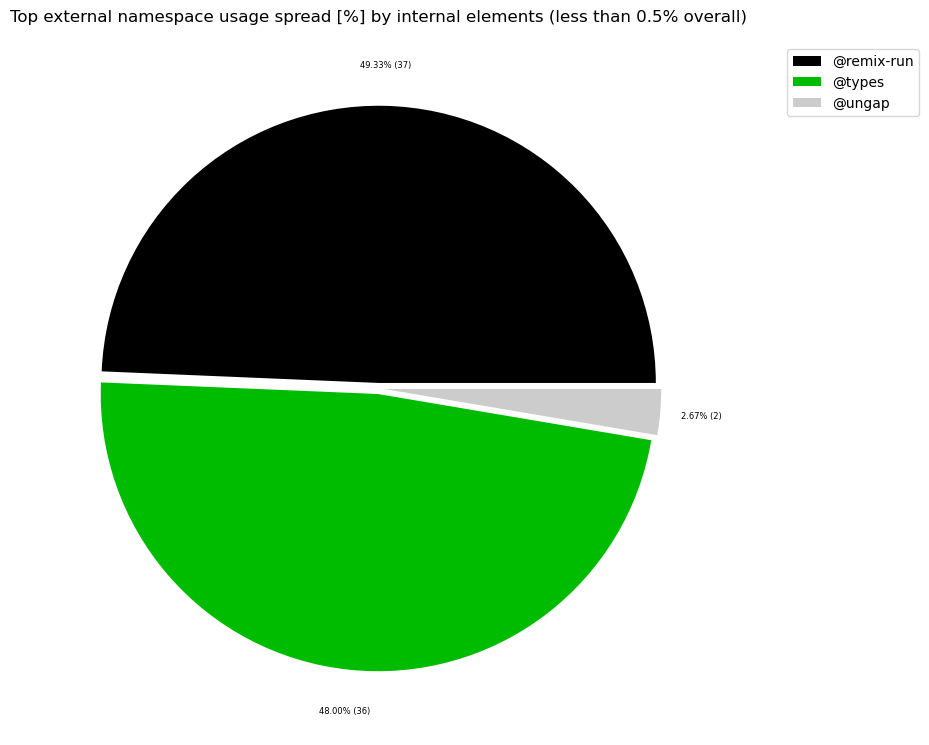

In [32]:
external_namespace_usage_significant = group_to_others_below_threshold(
    data_frame=external_namespace_usage_spread,
    value_column='sumNumberOfInternalElements',
    name_column='externalModuleNamespace',
    threshold= 0.5
);
plot_pie_chart(
    input_data_frame=external_namespace_usage_significant,
    title='Top external namespace usage spread [%] by internal elements (less than 0.5% overall)'
)

#### Table 4 Chart 1b - Most widely spread external namespaces in % by internal element (less than 0.5% overall "others" drill-down)

Shows the lowest (less than 0.5% overall) most widely spread external namespaces. Therefore, this plot breaks down the "others" slice of the pie chart above. Values under 0.3% from that will be grouped into "others" to get a cleaner plot.

In [33]:
external_namespace_usage_spread_drill_down_others=filter_values_below_threshold(external_namespace_usage_spread, 'sumNumberOfInternalElements', 0.5)

external_namespace_usage_spread_significant_drill_down_others = group_to_others_below_threshold(
    data_frame=external_namespace_usage_spread_drill_down_others,
    value_column='sumNumberOfInternalElements',
    name_column='externalModuleNamespace',
    threshold= 0.3
)
plot_pie_chart(
    input_data_frame=external_namespace_usage_spread_significant_drill_down_others,
    title='Top external namespace usage spread [%] by internal elements (less than 0.7% overall "others" drill-down)'
)

No data to plot for title 'Top external namespace usage spread [%] by internal elements (less than 0.7% overall "others" drill-down)'.


#### Table 4 Chart 2a - Most widely spread external namespace in % by internal modules (more than 0.5% overall)

External namespaces that are used less than 0.5% are grouped into "others" to get a cleaner chart
containing the most significant external namespaces and how ofter they are called in percent.

<Figure size 640x480 with 0 Axes>

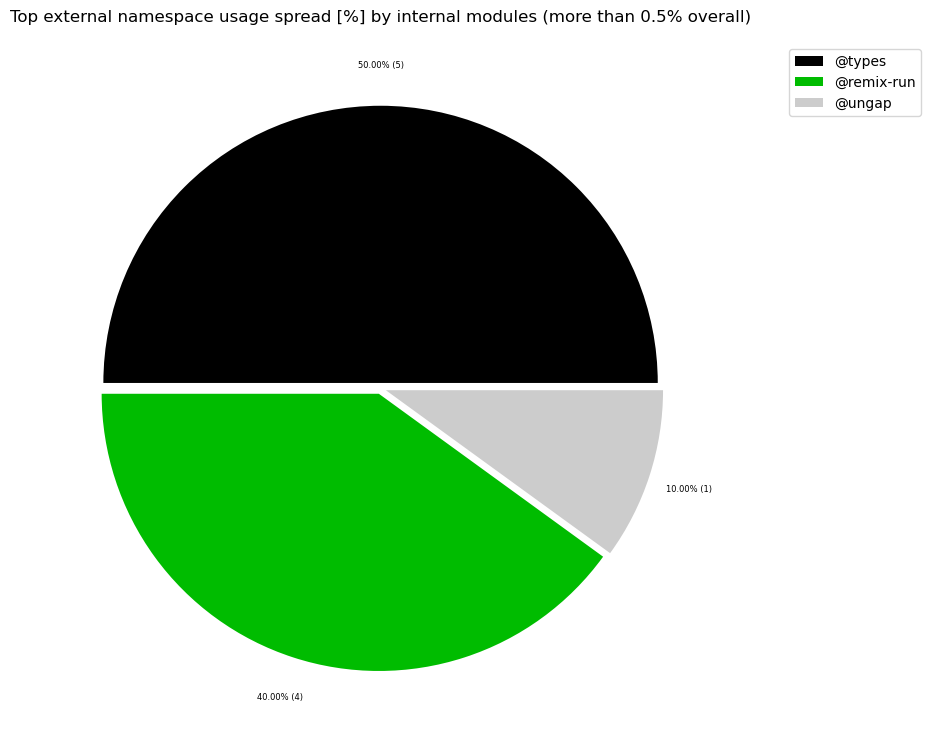

In [34]:
external_namespace_internal_module_usage_spread_significant = group_to_others_below_threshold(
    data_frame=external_namespace_usage_spread,
    value_column='numberOfInternalModules',
    name_column='externalModuleNamespace',
    threshold= 0.5
);
plot_pie_chart(
    input_data_frame=external_namespace_internal_module_usage_spread_significant,
    title='Top external namespace usage spread [%] by internal modules (more than 0.5% overall)'
)

#### Table 4 Chart 2b - Most widely spread external namespace in % by internal modules (less than 0.5% overall "others" drill-down)

Shows the lowest (less than 0.5% overall) most widely spread external namespaces. Therefore, this plot breaks down the "others" slice of the pie chart above. Values under 0.3% from that will be grouped into "others" to get a cleaner plot.

In [35]:
external_namespace_internal_module_usage_spread_drill_down_others=filter_values_below_threshold(external_namespace_usage_spread, 'numberOfInternalModules', 0.5)

external_namespace_internal_module_usage_spread_significant_drill_down_others = group_to_others_below_threshold(
    data_frame=external_namespace_internal_module_usage_spread_drill_down_others,
    value_column='numberOfInternalModules',
    name_column='externalModuleNamespace',
    threshold= 0.3
)
plot_pie_chart(
    input_data_frame=external_namespace_internal_module_usage_spread_significant_drill_down_others,
    title='Top external namespace usage spread [%] by internal modules (less than 0.7% overall "others" drill-down)'
)

No data to plot for title 'Top external namespace usage spread [%] by internal modules (less than 0.7% overall "others" drill-down)'.


#### Table 4 Chart 3a - External namespaces with the most used declarations in % (more than 0.5% overall)

External namespaces that are used less than 0.5% are grouped into "others" to get a cleaner chart
containing the most significant external namespaces and how ofter they are called in percent.

<Figure size 640x480 with 0 Axes>

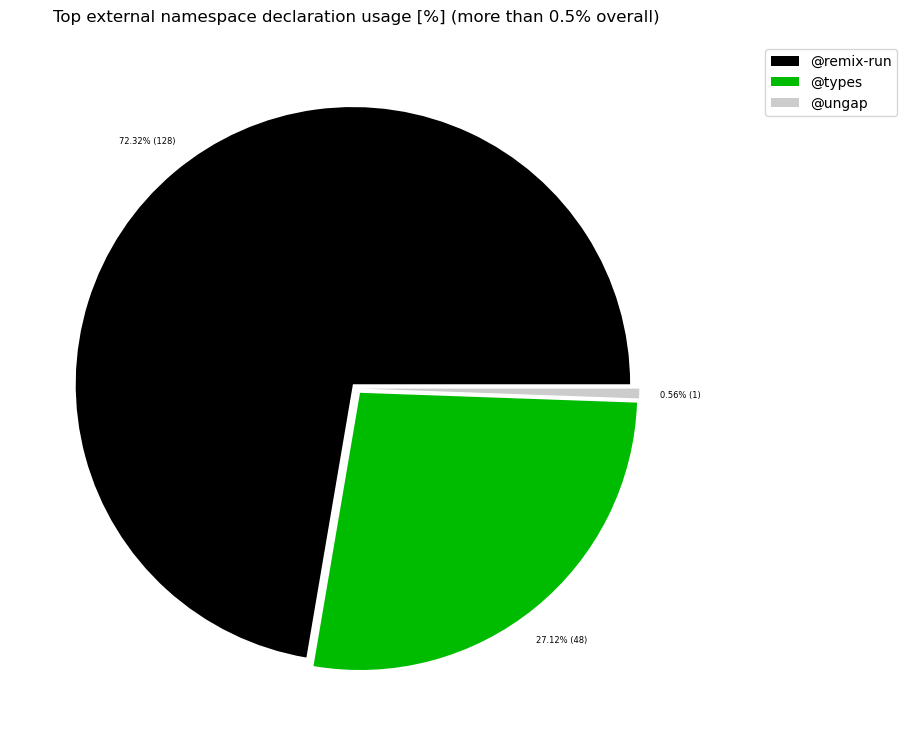

In [36]:
external_namespace_declaration_usage_significant = group_to_others_below_threshold(
    data_frame=external_namespace_usage_spread,
    value_column='sumNumberOfUsedExternalDeclarations',
    name_column='externalModuleNamespace',
    threshold= 0.5
);
plot_pie_chart(
    input_data_frame=external_namespace_declaration_usage_significant,
    title='Top external namespace declaration usage [%] (more than 0.5% overall)'
)

#### Table 4 Chart 3b - External namespaces with the most used declarations in % (less than 0.5% overall "others" drill-down)

Shows the lowest (less than 0.5% overall) external namespaces with the most used declarations. Therefore, this plot breaks down the "others" slice of the pie chart above. Values under 0.3% from that will be grouped into "others" to get a cleaner plot.

In [37]:
external_namespace_declaration_usage_drill_down_others=filter_values_below_threshold(external_namespace_usage_spread, 'sumNumberOfUsedExternalDeclarations', 0.5)

external_namespace_declaration_usage_significant_drill_down_others = group_to_others_below_threshold(
    data_frame=external_namespace_declaration_usage_drill_down_others,
    value_column='sumNumberOfUsedExternalDeclarations',
    name_column='externalModuleNamespace',
    threshold= 0.3
)
plot_pie_chart(
    input_data_frame=external_namespace_declaration_usage_significant_drill_down_others,
    title='Top external namespace declaration usage (less than 0.7% overall "others" drill-down)'
)

No data to plot for title 'Top external namespace declaration usage (less than 0.7% overall "others" drill-down)'.


### Table 5 - Top 20 least used external modules overall

This table identifies external modules that aren't used very often. This could help to find libraries that aren't actually needed or maybe easily replaceable. Some of them might be used sparsely on purpose for example as an adapter to an external library that is actually important. Thus, decisions need to be made on a case-by-case basis.

Only the last 20 entries are shown. The whole table can be found in the following CSV report:
`External_module_usage_overall_for_Typescript`

**Columns:**
- *externalModuleName* identifies the external package as described above
- *numberOfExternalDeclarationCalls* includes every invocation or reference to the declarations in the external module

In [38]:
# Sort by number of external type calls
external_package_least_used=external_module_usage.sort_values(by='numberOfExternalDeclarationCalls', ascending=True)

# Reset index
external_package_least_used = external_package_least_used.reset_index(drop=True)

# Select columns and only show the first 10 entries (head)
external_package_least_used[['externalModuleName','numberOfExternalDeclarationCalls']].head(20)


,externalModuleName,numberOfExternalDeclarationCalls
0,@ungap/url-search-params,4
1,@types/react-native,28
2,@types/react,195
3,@remix-run/router,380


### Table 6 - External usage per internal module sorted by highest external element usage rate descending

The following table shows the most used external packages separately for each artifact including external annotations. The results are sorted by the artifacts with the highest external type usage rate descending. 

The intention of this table is to find artifacts that use a lot of external dependencies in relation to their size and get all the external packages and their usage.

Only the first 40 entries are shown. The whole table can be found in the following CSV report:
`External_module_usage_per_internal_module_sorted_for_Typescript`

**Columns:**
- *internalModuleName* is the internal module that uses the external one. Both are used here as a group for a more detailed analysis.
- *externalModuleName* is the external module prepended by its namespace if given. Example: "@types/react"
- *numberOfExternalDeclarationCaller* is the count of distinct internal elements in the internal module that call the external module
- *numberOfExternalDeclarationCalls* is the count of how often the external module is called within the internal module
- *numberOfAllElementsInInternalModule* is the total count of all exported elements of the internal module
- *numberOfAllExternalDeclarationsUsedInInternalModule* is the total count of all distinct external declarations used in the internal module
- *numberOfAllExternalModulesUsedInInternalModule* is the total count of all distinct external modules used in the internal module
- *externalDeclarationRate* is the numberOfAllExternalDeclarationsUsedInInternalModule / numberOfAllElementsInInternalModule * 100 of the internal module for all external modules
- *externalDeclarationNames* contains a list of actually used external declarations

#### Table 6a - External module usage per internal module sorted by highest external element usage rate descending

In [39]:
external_modules_used_by_internal_modules = query_cypher_to_data_frame("../cypher/External_Dependencies/External_module_usage_per_internal_module_sorted_for_Typescript.cypher")
external_modules_used_by_internal_modules.head(40)

,internalModuleName,externalModuleName,numberOfExternalDeclarationCaller,numberOfExternalDeclarationCalls,numberOfAllElementsInInternalModule,numberOfAllExternalDeclarationsUsedInInternalModule,numberOfAllExternalModulesUsedInInternalModule,externalDeclarationRate,externalDeclarationNames
0,server,@remix-run/router,72,126,6,28,2,466.666667,"[Action, IDLE_NAVIGATION, StaticHandlerContext..."
1,server,@types/react,6,30,6,28,2,466.666667,"[React.ReactNode, React.JSX.Element]"
2,react-router-dom,@remix-run/router,274,486,62,115,2,185.483871,"[HTMLFormMethod.toLowerCase, Router, Router.in..."
3,react-router-dom,@types/react,166,496,62,115,2,185.483871,"[React.JSX.Element, React.FormEvent.defaultPre..."
4,react-router-native,@types/react-native,22,49,17,24,4,141.176471,"[GestureResponderEvent, TouchableHighlightProp..."
5,react-router-native,@remix-run/router,18,41,17,24,4,141.176471,"[To, MemoryRouterProps, useLocation, Location...."
6,react-router-native,@types/react,18,49,17,24,4,141.176471,"[React.ReactNode, React.JSX.Element, React.use..."
7,react-router-native,@ungap/url-search-params,4,8,17,24,4,141.176471,[url-search-params]
8,react-router,@remix-run/router,16,20,7,9,2,128.571429,"[DataStrategyFunction, Router.initialize, crea..."
9,react-router,@types/react,2,6,7,9,2,128.571429,[React.createElement]


#### Table 6b - External namespace usage per internal module sorted by highest external element usage rate descending

In [40]:
external_namespaces_used_by_internal_modules = query_cypher_to_data_frame("../cypher/External_Dependencies/External_namespace_usage_per_internal_module_sorted_for_Typescript.cypher")
external_namespaces_used_by_internal_modules.head(40)

,internalModuleName,externalNamespaceName,numberOfExternalDeclarationCaller,numberOfExternalDeclarationCalls,numberOfAllElementsInInternalModule,numberOfAllExternalDeclarationsUsedInInternalModule,numberOfAllExternalModulesUsedInInternalModule,externalDeclarationRate,externalDeclarationNames
0,server,@remix-run,72,126,6,28,2,466.666667,"[Action, IDLE_NAVIGATION, StaticHandlerContext..."
1,server,@types,6,30,6,28,2,466.666667,"[React.ReactNode, React.JSX.Element]"
2,react-router-dom,@remix-run,274,486,62,115,2,185.483871,"[HTMLFormMethod.toLowerCase, Router, Router.in..."
3,react-router-dom,@types,166,496,62,115,2,185.483871,"[React.JSX.Element, React.FormEvent.defaultPre..."
4,react-router-native,@types,40,98,17,24,4,141.176471,"[React.ReactNode, GestureResponderEvent, Touch..."
5,react-router-native,@remix-run,18,41,17,24,4,141.176471,"[To, MemoryRouterProps, useLocation, Location...."
6,react-router-native,@ungap,4,8,17,24,4,141.176471,[url-search-params]
7,react-router,@remix-run,16,20,7,9,2,128.571429,"[DataStrategyFunction, Router.initialize, crea..."
8,react-router,@types,2,6,7,9,2,128.571429,[React.createElement]
9,App,@types,1,1,1,1,1,100.000000,[React.JSX.Element]


#### Table 6c - Top 15 used external modules with the internal modules that use them the most

The following table uses pivot to show the internal modules in columns, the external modules in rows and the number of internal elements using them as values.

In [41]:
# Calculate the percentage for each value based on the global sum of all values
def percentage_global(data_frame : pd.DataFrame):
    total = data_frame.sum().sum()
    return data_frame / total * 100

In [42]:
external_modules_used_by_internal_modules_pivot = external_modules_used_by_internal_modules.copy()

# Every row represents the number of external module
external_modules_used_by_internal_modules_pivot=external_modules_used_by_internal_modules_pivot.pivot(index='externalModuleName', columns='internalModuleName', values='numberOfExternalDeclarationCaller')

# Sort by column sum and then take only the first 10 columns
sum_of_external_packages_per_artifact = external_modules_used_by_internal_modules_pivot.sum()
external_modules_used_by_internal_modules_pivot = external_modules_used_by_internal_modules_pivot[sum_of_external_packages_per_artifact.sort_values(ascending=False).index[:15]]

# Fill missing values with zeroes
external_modules_used_by_internal_modules_pivot.fillna(0, inplace=True)

external_modules_used_by_internal_modules_pivot.astype('int')

internalModuleName,react-router-dom,server,react-router-native,react-router,App
externalModuleName,,,,,
@remix-run/router,274,72,18,16,0
@types/react,166,6,18,2,1
@types/react-native,0,0,22,0,0
@ungap/url-search-params,0,0,4,0,0


#### Table 6d - Top 15 used external namespaces with the internal modules that use them the most

The following table uses pivot to show the internal modules in columns, the external namespaces in rows and the number of internal elements using them as values.

In [43]:
external_namespaces_used_by_internal_modules_pivot = external_namespaces_used_by_internal_modules.copy()

# Every row represents the number of external module
external_namespaces_used_by_internal_modules_pivot=external_namespaces_used_by_internal_modules_pivot.pivot(index='externalNamespaceName', columns='internalModuleName', values='numberOfExternalDeclarationCaller')

# Sort by column sum and then take only the first 10 columns
sum_of_external_second_level_packages_per_artifact = external_namespaces_used_by_internal_modules_pivot.sum()
external_namespaces_used_by_internal_modules_pivot = external_namespaces_used_by_internal_modules_pivot[sum_of_external_second_level_packages_per_artifact.sort_values(ascending=False).index[:15]]

# Fill missing values with zeroes
external_namespaces_used_by_internal_modules_pivot.fillna(0, inplace=True)

external_namespaces_used_by_internal_modules_pivot.astype('int')

internalModuleName,react-router-dom,server,react-router-native,react-router,App
externalNamespaceName,,,,,
@remix-run,274,72,18,16,0
@types,166,6,40,2,1
@ungap,0,0,4,0,0


### Table 6e - External usage per internal module and its elements

This table lists internal elements and the modules they belong to that use many different external declarations of a specific external module. 

In [44]:
# Sort by number of packages descending
internal_modules_with_highest_external_declaration_usage = external_modules_used_by_internal_modules.copy()
internal_modules_with_highest_external_declaration_usage.sort_values(by=['numberOfAllExternalDeclarationsUsedInInternalModule','internalModuleName'], ascending=[False, True]).reset_index(drop=True)
internal_modules_with_highest_external_declaration_usage=internal_modules_with_highest_external_declaration_usage[['internalModuleName', 'numberOfAllExternalDeclarationsUsedInInternalModule', 'numberOfAllElementsInInternalModule']]
internal_modules_with_highest_external_declaration_usage=internal_modules_with_highest_external_declaration_usage.drop_duplicates()
internal_modules_with_highest_external_declaration_usage.head(40)

,internalModuleName,numberOfAllExternalDeclarationsUsedInInternalModule,numberOfAllElementsInInternalModule
0,server,28,6
2,react-router-dom,115,62
4,react-router-native,24,17
8,react-router,9,7
10,App,1,1


#### Table 6 Chart 1 - Top 15 external dependency using artifacts and their external packages stacked

The following chart shows the top 15 external package using artifacts and breaks down which external packages they use in how many different internal packages with stacked bars. 

Note that every external dependency is counted separately so that if on internal package uses two external packages it will be displayed for both and so stacked twice.  

<Figure size 640x480 with 0 Axes>

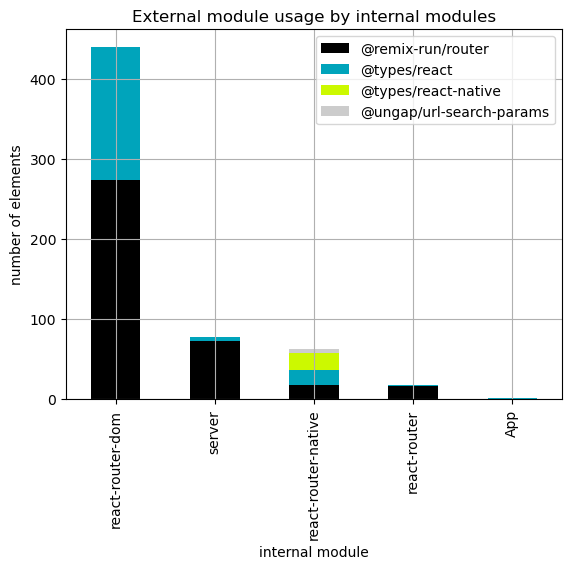

In [45]:
if external_modules_used_by_internal_modules_pivot.empty:
    print("No data to plot")
else:
    plot.figure();
    axes = external_modules_used_by_internal_modules_pivot.transpose().plot(
        kind='bar', 
        grid=True,
        title='External module usage by internal modules', 
        xlabel='internal module',
        ylabel='number of elements',
        stacked=True,
        legend=True,
        cmap=main_color_map
    ).legend(bbox_to_anchor=(1.0, 1.0))
    plot.show()

#### Table 6 Chart 2 - Top 15 external dependency using artifacts and their external packages (first 2 levels) stacked

The following chart shows the top 15 external package using artifacts and breaks down which external packages (first 2 levels) are used in how many different internal packages with stacked bars. 

Note that every external dependency is counted separately so that if on internal package uses two external packages it will be displayed for both and so stacked twice.  

<Figure size 640x480 with 0 Axes>

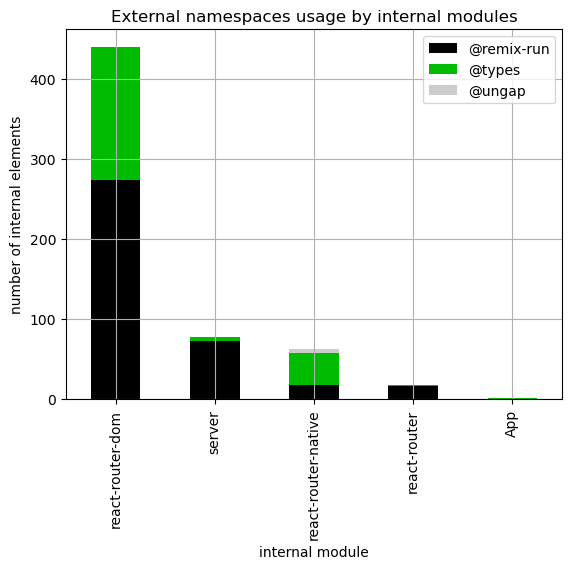

In [46]:
if external_namespaces_used_by_internal_modules_pivot.empty:
    print("No data to plot")
else:
    plot.figure();
    axes = external_namespaces_used_by_internal_modules_pivot.transpose().plot(
        kind='bar', 
        grid=True,
        title='External namespaces usage by internal modules', 
        xlabel='internal module',
        ylabel='number of internal elements',
        stacked=True,
        legend=True,
        cmap=main_color_map
    ).legend(bbox_to_anchor=(1.0, 1.0))
    plot.show()

### Table 7 - External module usage distribution per internal element

This table shows how many internal elements use one external module, how many use two, etc. .
This gives an overview of the distribution of external module calls and the overall coupling to external libraries. The higher the count of distinct external modules the lower should be the count of internal elements that use them. 
More details about which types have the highest external package dependency usage can be in the tables 4 and 5 above.

Only the last 40 entries are shown. The whole table can be found in the following CSV report:
`External_module_usage_per_internal_module_distribution_for_Typescript`

**Columns:**
- *internalModuleName* is the internal module that uses at least one external module. All other columns refer to it.
- *numberOfAllInternalElements* the total number of all elements that are exported by the internal module
- *externalModuleCount* is the number of distinct external modules used by the internal module
- *internalElementCount* is the number of distinct internal elements that use at least one external one
- *internalElementsCallingExternalRate* is internalElementCount / numberOfAllInternalElements * 100 (in %)

In [47]:
external_package_usage_per_artifact_distribution = query_cypher_to_data_frame("../cypher/External_Dependencies/External_module_usage_per_internal_module_distribution_for_Typescript.cypher")
external_package_usage_per_artifact_distribution_truncated=external_package_usage_per_artifact_distribution[['internalModuleName', 'numberOfAllInternalElements', 'externalModuleCount', 'internalElementCount', 'internalElementsCallingExternalRate']].head(40)
external_package_usage_per_artifact_distribution_truncated

,internalModuleName,numberOfAllInternalElements,externalModuleCount,internalElementCount,internalElementsCallingExternalRate
0,react-router-dom,62,2,29,46.774194
1,react-router-native,17,4,10,58.823529
2,server,6,2,6,100.000000
3,react-router,7,2,3,42.857143
4,App,1,1,1,100.000000


### Table 8 - External package usage aggregated

This table lists all artifacts and their external package dependencies usage aggregated over internal packages. 

The intention behind this is to find artifacts that use an external dependency across multiple internal packages. This might be intended for frameworks and standardized libraries and helps to quantify how widely those are used. For some external dependencies it might be beneficial to only access it from one package and provide an abstraction for internal usage following a [Hexagonal architecture](https://alistair.cockburn.us/hexagonal-architecture). Thus, this table may also help in finding application for the Hexagonal architecture or similar approaches (Domain Driven Design Anti Corruption Layer). After all it is easier to update or replace such external dependencies when they are used in specific areas and not all over the code.

Only the last 40 entries are shown. The whole table can be found in the following CSV report:
`External_module_usage_per_internal_module_aggregated_for_Typescript`

**Columns:**
- *internalModuleName* that contains the type that calls the external package
- *internalModuleElementsCount* is the total count of packages in the internal module
- *numberOfExternalModules* the number of distinct external packages used
- *[min,max,med,avg,std]NumberOfInternalModules* provide statistics based on each external package and its package usage within the internal module
- *[min,max,med,avg,std]NumberOfInternalElements* provide statistics based on each external package and its type usage within the internal module
- *[min,max,med,avg,std]NumberOfTypePercentage* provide statistics in % based on each external package and its type usage within the internal module in respect to the overall count of packages in the internal module
- *numberOfinternalElements* in the internal module where the *numberOfExternalModules* applies
- *numberOfTypesPercentage* in the internal module where the *numberOfExternalModules* applies in %

#### Table 8a - External module usage aggregated - count of internal modules

In [48]:
external_package_usage_aggregated = query_cypher_to_data_frame("../cypher/External_Dependencies/External_module_usage_per_internal_module_aggregated_for_Typescript.cypher")

external_package_usage_aggregated_packages = external_package_usage_aggregated[['internalModuleName', 'internalModuleElementsCount', 'numberOfExternalModules', 'minNumberOfInternalModules', 'medNumberOfInternalModules', 'avgNumberOfInternalModules', 'maxNumberOfInternalModules', 'stdNumberOfInternalModules']]
external_package_usage_aggregated_packages.head(30)

,internalModuleName,internalModuleElementsCount,numberOfExternalModules,minNumberOfInternalModules,medNumberOfInternalModules,avgNumberOfInternalModules,maxNumberOfInternalModules,stdNumberOfInternalModules
0,App,1,1,1,1.0,1.0,1,0.0
1,react-router,7,2,1,1.0,1.0,1,0.0
2,react-router-dom,62,2,1,1.0,1.0,1,0.0
3,react-router-native,17,4,1,1.0,1.0,1,0.0
4,server,6,2,1,1.0,1.0,1,0.0


#### Table 8b - External module usage aggregated - count of internal elements

In [49]:
external_package_usage_aggregated_types = external_package_usage_aggregated[['internalModuleName', 'internalModuleElementsCount', 'numberOfExternalModules', 'minNumberOfInternalElements', 'medNumberOfInternalElements', 'avgNumberOfInternalElements', 'maxNumberOfInternalElements', 'stdNumberOfInternalElements']]
external_package_usage_aggregated_types.head(30)

,internalModuleName,internalModuleElementsCount,numberOfExternalModules,minNumberOfInternalElements,medNumberOfInternalElements,avgNumberOfInternalElements,maxNumberOfInternalElements,stdNumberOfInternalElements
0,App,1,1,1,1.0,1.00,1,0.000000
1,react-router,7,2,1,2.0,2.00,3,1.414214
2,react-router-dom,62,2,23,23.5,23.50,24,0.707107
3,react-router-native,17,4,2,5.5,4.75,6,1.892969
4,server,6,2,3,4.0,4.00,5,1.414214


#### Table 8c - External module usage aggregated - percentage of internal elements

In [50]:
external_package_usage_aggregated_types_percentage = external_package_usage_aggregated[['internalModuleName', 'internalModuleElementsCount', 'numberOfExternalModules', 'minNumberOfInternalElementsPercentage', 'medNumberOfInternalElementsPercentage', 'avgNumberOfInternalElementsPercentage', 'maxNumberOfInternalElementsPercentage', 'stdNumberOfInternalElementsPercentage']]
external_package_usage_aggregated_types_percentage.head(30)

,internalModuleName,internalModuleElementsCount,numberOfExternalModules,minNumberOfInternalElementsPercentage,medNumberOfInternalElementsPercentage,avgNumberOfInternalElementsPercentage,maxNumberOfInternalElementsPercentage,stdNumberOfInternalElementsPercentage
0,App,1,1,100.000000,100.000000,100.000000,100.000000,0.000000
1,react-router,7,2,14.285714,28.571429,28.571429,42.857143,20.203051
2,react-router-dom,62,2,37.096774,37.903226,37.903226,38.709677,1.140495
3,react-router-native,17,4,11.764706,32.352941,27.941176,35.294118,11.135114
4,server,6,2,50.000000,66.666667,66.666667,83.333333,23.570226


#### Table 8 Chart 1 - External module usage - max percentage of internal types

This chart shows per internal module the maximum percentage of internal packages (compared to all packages in that internal module) that use one specific external package. 

**Example:** One internal module might use 10 external packages where 7 of them are used in one internal package, 2 of them are used in two packages and one external dependency is used in 5 packages. So for this internal module there will be a point at x = 10 (external packages used by the internal module) and 5 (max internal packages). Instead of the count the percentage of internal packages compared to all packages in that internal module is used to get a normalized plot.

In [51]:
def annotate_plot(data_frame: pd.DataFrame, index: int):
    """
    Annotates the data points identified by the "index" in the plot of the "data_frame" 
    """
    x_position = data_frame.numberOfExternalModules[index].item()
    y_position = data_frame.maxNumberOfInternalElementsPercentage[index].item()
    artifact_name = data_frame.internalModuleName[index].item()

    label_box=dict(boxstyle="round4,pad=0.5", fc="w", alpha=0.8)
    plot.annotate(artifact_name
        ,xy=(x_position, y_position)
        ,xycoords='data'
        ,xytext=(-30, -15)
        ,textcoords='offset points'
        ,size=6
        ,bbox=label_box
        ,arrowprops=dict(arrowstyle="-|>", mutation_scale=10, color="black")
    )

In [52]:
def index_of_sorted(data_frame: pd.DataFrame, highest: list[str] = []):
    """
    Sorts the "data_frame" by columns 'numberOfExternalModules','maxNumberOfInternalElementsPercentage','internalModuleElementsCount', 'internalModuleName'
    and returns the index of the first row.
    Columns that are contained in the list of strings parameter "highest" will be sorted descending (highest first).
    """
    by = ['numberOfExternalModules','maxNumberOfInternalElementsPercentage','internalModuleElementsCount', 'internalModuleName']
    ascending = [('numberOfExternalModules' not in highest), ('maxNumberOfInternalElementsPercentage' not in highest), False, True]
    return data_frame.sort_values(by=by, ascending=ascending).head(1).index

<Figure size 640x480 with 0 Axes>

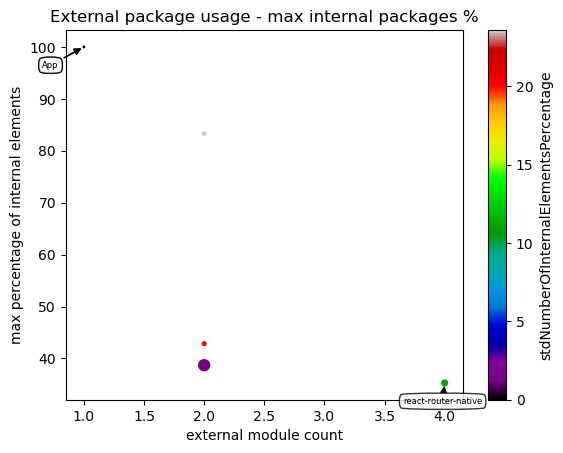

In [53]:
if external_package_usage_aggregated.empty:
    print("No data to plot")
else:
    plot.figure();
    axes = external_package_usage_aggregated.plot(
        kind='scatter',
        title='External package usage - max internal packages %', 
        x='numberOfExternalModules',
        y='maxNumberOfInternalElementsPercentage',
        s='internalModuleElementsCount',
        c='stdNumberOfInternalElementsPercentage',
        xlabel='external module count',
        ylabel='max percentage of internal elements',
        cmap=main_color_map,
    )

    # Annotate the largest internal module with the highest number of external packages and max number of packages in percentage
    annotation_index = index_of_sorted(highest=['numberOfExternalModules','maxNumberOfInternalElementsPercentage'], data_frame=external_package_usage_aggregated)
    annotate_plot(external_package_usage_aggregated, annotation_index)


    # Annotate the largest internal module with the lowest number of external packages and the highest max number of packages in percentage
    annotation_index = index_of_sorted(highest=['maxNumberOfInternalElementsPercentage'], data_frame=external_package_usage_aggregated)
    annotate_plot(external_package_usage_aggregated, annotation_index)

    # Annotate the largest internal module with the lowest number of external packages and max number of packages in percentage
    annotation_index = index_of_sorted(highest=[], data_frame=external_package_usage_aggregated)
    annotate_plot(external_package_usage_aggregated, annotation_index)

    plot.show()

#### Table 8 Chart 2 - External package usage - median percentage of internal types

This chart shows per internal module the median (0.5 percentile) of internal packages (compared to all packages in that internal module) that use one specific external package. 

**Example:** One internal module might use 9 external packages where 3 of them are used in 1 internal package, 3 of them are used in 2 package and the last 3 ones are used in 3 packages. So for this internal module there will be a point at x = 10 (external packages used by the internal module) and 2 (median internal packages). Instead of the count the percentage of internal packages compared to all packages in that internal module is used to get a normalized plot.

<Figure size 640x480 with 0 Axes>

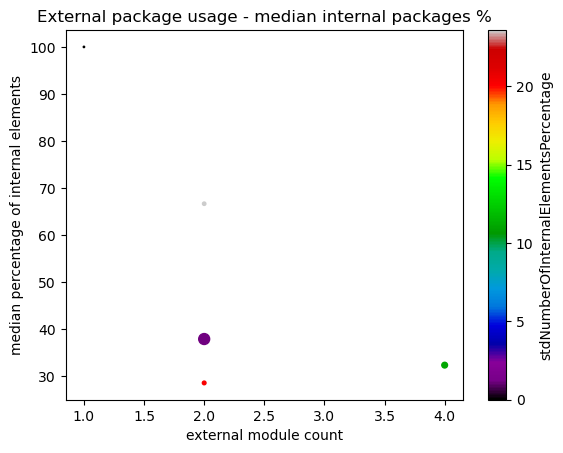

In [54]:
if external_package_usage_aggregated.empty:
    print("No data to plot")
else:
    plot.figure();
    axes = external_package_usage_aggregated.plot(
        kind='scatter',
        title='External package usage - median internal packages %', 
        x='numberOfExternalModules',
        y='medNumberOfInternalElementsPercentage',
        s='internalModuleElementsCount',
        c='stdNumberOfInternalElementsPercentage',
        xlabel='external module count',
        ylabel='median percentage of internal elements',
        cmap=main_color_map,
    )
    plot.show()

In [55]:
driver.close()